## A Typical Tensorflow-Keras based CNN model

In [1]:
# Importing library needed for building the CNN model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
# usual imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

### Data Handling

In [3]:
from tensorflow.keras.datasets import fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images = train_images/255
test_images = test_images/255 

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)

In [8]:
train_images.shape

(60000, 28, 28, 1)

### Model Construction

In [9]:
#pip install keras-tuner

In [10]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [11]:
#hp signifies hyperparameters we are going to tune
def build_model(hp):
    #i.define model
    cnn = Sequential()
    #first convolution layer
    cnn.add(Conv2D(filters=hp.Int("conv_1_filter", min_value=16, max_value=128, step=16),
                   padding="same", kernel_size=hp.Choice("conv_1_kernel", values=[3,5]),
                   activation='relu', strides=2, input_shape=[28, 28, 1]))
    #maxpooling
    cnn.add(MaxPool2D(pool_size=2, strides=2))
    
    #second convolution layer
    cnn.add(Conv2D(filters=hp.Int("conv_2_filter", min_value=16, max_value=128, step=16),
                   padding='same', kernel_size=hp.Choice("conv_2_kernel", values=[3,5]),
                   activation='relu'))
    #maxpooling
    cnn.add(MaxPool2D(pool_size=2, strides=2))
    
    #flattening
    cnn.add(Flatten())
    
    #fully connected dense layer
    cnn.add(Dense(units=hp.Int("dense_1_units", min_value=16, max_value=128, step=16),
                  activation='relu'))
    
    #output Layer
    cnn.add(Dense(units=10, activation='softmax'))
    
    #ii.compile the model
    #we have to define the optimizer, loss function and evaluating metric while compiling the model
    #hp.Choice signifies the choice is from a list
    cnn.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-2,1e-3,1e-4])),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return cnn

In [12]:
tuner = RandomSearch(build_model, objective='val_accuracy',
                    max_trials=10, directory="project2",
                    project_name="fashion_mnist")

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [14]:
tuner.search(train_images, train_labels, epochs=2, validation_split=0.15)

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.8911111354827881

Best val_accuracy So Far: 0.8928889036178589
Total elapsed time: 00h 01m 47s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

Results summary
Results in project2/fashion_mnist
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 112
conv_2_kernel: 3
dense_1_units: 112
learning_rate: 0.001
Score: 0.8928889036178589
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
conv_2_filter: 112
conv_2_kernel: 5
dense_1_units: 112
learning_rate: 0.001
Score: 0.8911111354827881
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 3
conv_2_filter: 96
conv_2_kernel: 3
dense_1_units: 128
learning_rate: 0.001
Score: 0.8834444284439087
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 5
dense_1_units: 48
learning_rate: 0.01
Score: 0.8741111159324646
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
conv_2_filter: 80
conv_2_kernel: 3
dense_1_units: 112
learning_rate: 0.01
Score: 0.862333357334137
Trial summary
Hyperparameters:
conv_1_filter:

In [19]:
model = tuner.get_best_models(num_models=1)[0]

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 112)       1120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 112)         113008    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 112)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 112)               113008    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [21]:
#fit
model_history = model.fit(train_images, train_labels, validation_split=0.2, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2654 - accuracy: 0.9016 - val_loss: 0.2631 - val_accuracy: 0.9049
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2336 - accuracy: 0.9124 - val_loss: 0.2701 - val_accuracy: 0.9023
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2053 - accuracy: 0.9255 - val_loss: 0.2613 - val_accuracy: 0.9076
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1793 - accuracy: 0.9325 - val_loss: 0.2788 - val_accuracy: 0.9043
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1574 - accuracy: 0.9417 - val_loss: 0.2962 - val_accuracy: 0.8941
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1435 - accuracy: 0.9465 - val_loss: 0.2800 - val_accuracy: 0.9052
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1203 - accuracy: 0.9549 - val_loss: 0.2761 - val_accuracy:

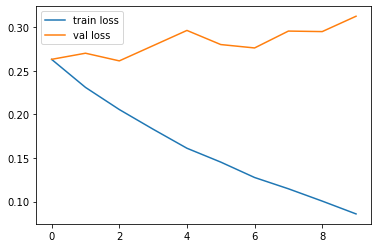

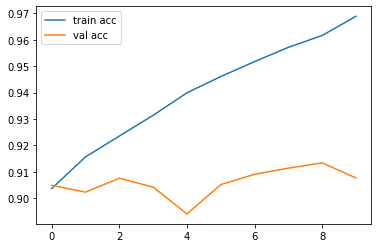

In [23]:
# plot the loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(test_images)
y_pred

array([[2.81720437e-12, 1.12298944e-13, 3.73155777e-11, ...,
        5.55902666e-08, 1.24860539e-10, 9.99999762e-01],
       [3.08130438e-06, 3.09165427e-13, 9.99991775e-01, ...,
        1.77370217e-13, 3.41301900e-12, 7.17921382e-13],
       [3.60968685e-11, 1.00000000e+00, 1.63446734e-09, ...,
        4.28058476e-16, 2.97342514e-14, 4.11082295e-16],
       ...,
       [1.29565592e-09, 5.31573507e-19, 5.81384463e-12, ...,
        2.32218768e-16, 1.00000000e+00, 1.14676816e-15],
       [1.18289753e-11, 1.00000000e+00, 1.55226916e-12, ...,
        1.52002189e-10, 7.30302763e-11, 5.13010537e-11],
       [5.77900956e-11, 1.76915589e-16, 1.84778663e-08, ...,
        1.48948018e-07, 5.58084601e-09, 1.18455123e-09]], dtype=float32)

In [25]:
y_pred[0]

array([2.81720437e-12, 1.12298944e-13, 3.73155777e-11, 5.46326188e-14,
       6.02712324e-12, 2.11276642e-07, 7.85820020e-11, 5.55902666e-08,
       1.24860539e-10, 9.99999762e-01], dtype=float32)

In [26]:
y_pred_int = np.argmax(y_pred, axis=1)
y_pred_int

array([9, 2, 1, ..., 8, 1, 5])

In [27]:
y_pred_int[0:10]

array([9, 2, 1, 1, 6, 1, 4, 4, 5, 7])

In [28]:
#save the model as a h5 file
model.save("fashion_mnist.h5")

In [11]:
model=load_model('fashion_mnist.h5')

In [12]:
y_pred = model.predict(test_images)
y_pred

array([[2.8171721e-12, 1.1229723e-13, 3.7315220e-11, ..., 5.5590057e-08,
        1.2486077e-10, 9.9999976e-01],
       [3.0813017e-06, 3.0916366e-13, 9.9999177e-01, ..., 1.7736650e-13,
        3.4130060e-12, 7.1791179e-13],
       [3.6096865e-11, 1.0000000e+00, 1.6344736e-09, ..., 4.2804704e-16,
        2.9734024e-14, 4.1107605e-16],
       ...,
       [1.2956832e-09, 5.3155526e-19, 5.8139001e-12, ..., 2.3221967e-16,
        1.0000000e+00, 1.1467680e-15],
       [1.1828795e-11, 1.0000000e+00, 1.5522514e-12, ..., 1.5199929e-10,
        7.3030415e-11, 5.1299978e-11],
       [5.7790103e-11, 1.7691154e-16, 1.8477444e-08, ..., 1.4894788e-07,
        5.5807612e-09, 1.1845377e-09]], dtype=float32)

In [13]:
y_pred_int = np.argmax(y_pred, axis=1)
y_pred_int

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(test_labels, y_pred_int)

array([[823,   2,  25,  14,   2,   3, 127,   0,   4,   0],
       [  2, 974,   0,  14,   8,   0,   0,   0,   2,   0],
       [  9,   1, 893,   6,  55,   0,  36,   0,   0,   0],
       [ 22,   1,  10, 908,  29,   0,  29,   0,   1,   0],
       [  0,   0,  64,  19, 881,   0,  34,   0,   2,   0],
       [  1,   0,   0,   0,   0, 989,   0,   2,   0,   8],
       [103,   1,  88,  24,  92,   0, 687,   0,   5,   0],
       [  0,   0,   0,   0,   0,  42,   0, 928,   0,  30],
       [  6,   1,   2,   4,   2,   4,   1,   2, 976,   2],
       [  0,   0,   1,   0,   0,   7,   0,  19,   0, 973]], dtype=int64)

In [16]:
accuracy_score(test_labels, y_pred_int)

0.9032